In [1]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import jax

from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix
from loss import create_loss
from network import init_net, compute_end_to_end, compute_factor, kwon_compress_network
from solver import train
from utils import compose, svd

## Generating Data

In [2]:
key = PRNGKey(0)

# Simulated Data
d = 100
r = 5

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

key, subkey = split(key)
percent_observed = 0.2
mask = generate_observation_matrix(key=subkey, percent_observed=percent_observed, shape=(d, d))

train_loss_fn = create_loss(target, mask=mask)
test_loss_fn = create_loss(target, mask=1-mask)
loss_fn_dict = {
    'train': train_loss_fn,
    'test': test_loss_fn
}
network_fn = compute_end_to_end

2023-10-09 13:50:47.863531: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Original Network

In [3]:
depth = 3
init_scale = 1e-2

key, subkey = split(key)

# Instatiating the original wide network
init_weights = init_net(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-10
step_size = 1e1
n_outer_loops = 1000
n_inner_loops = 100

In [4]:
orig_result = train(
    init_weights=init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Compressed Network

In [7]:
# Construct surrogate target matrix for matrix completion
surrogate_target = ( 1/percent_observed ) * target * mask
comp_init_weights, factors = kwon_compress_network(target=surrogate_target, grad_rank=2*r, init_scale=init_scale, depth=depth)
new_comp_init_weights = [comp_init_weights[1]@comp_init_weights[0], comp_init_weights[2], comp_init_weights[4]@comp_init_weights[3]]

In [10]:
dlrs = jnp.arange(start=0.5, stop=10, step=0.25)

comp_result_times = []
comp_result_iters = []

for dlr in dlrs:
    print('Discrepant LR:', dlr)
    comp_result = train(
        init_weights=new_comp_init_weights,
        network_fn=network_fn,
        loss_fn_dict=loss_fn_dict,
        n_outer_loops=n_outer_loops,
        step_size=step_size,
        dlr=dlr,
        tol=tol,
        n_inner_loops=n_inner_loops,
        save_weights=True
    )

    comp_result_times.append(comp_result['time'][-1])
    comp_result_iters.append(len(comp_result['weights']))

Discrepant LR: 0.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 0.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 1.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 1.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 1.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 2.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 2.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 2.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 2.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 3.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 3.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 3.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 3.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 4.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 4.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 4.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 4.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 5.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 5.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 5.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 5.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 6.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 6.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 6.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 6.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 7.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 7.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 7.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 7.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 8.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 8.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 8.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 8.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 9.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 9.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 9.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Discrepant LR: 9.75


  0%|          | 0/1000 [00:00<?, ?it/s]

## Plotting

In [11]:
orig_result_times = [orig_result['time'][-1]]*len(dlrs)
orig_result_iters = [len(orig_result['time'])]*len(dlrs)

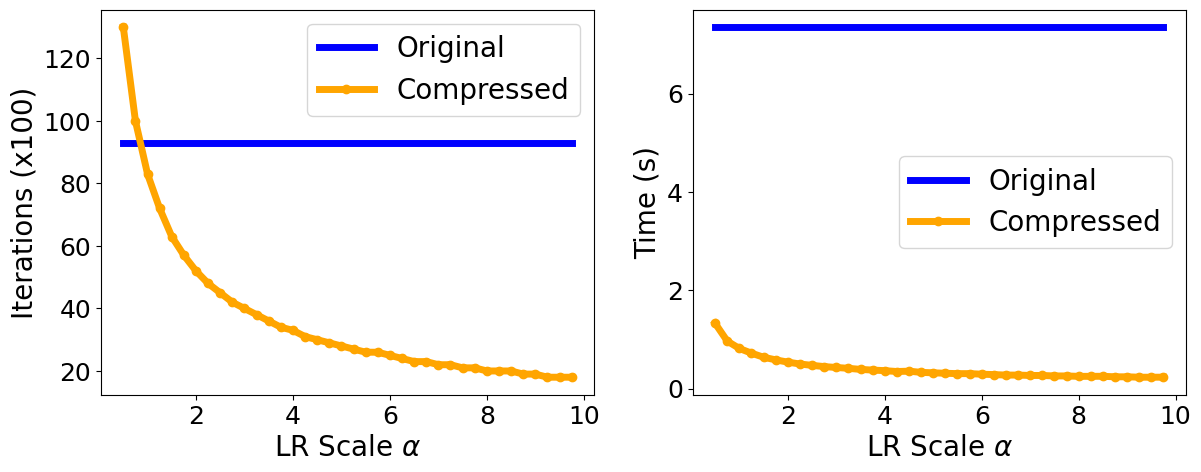

In [15]:
fig = plt.figure(figsize=(14, 5))

ax = fig.add_subplot(121)

ax.plot(dlrs, orig_result_iters, c='blue', linewidth=5, label='Original')
ax.plot(dlrs, comp_result_iters, c='orange', marker='o', linewidth=5, label='Compressed')
ax.set_xlabel(r'LR Scale $\alpha$', fontsize=20)
ax.set_ylabel(rf'Iterations (x{n_inner_loops})', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

#ax.set_title(rf'$\epsilon=${init_scale}')
ax = fig.add_subplot(122)

ax.plot(dlrs, orig_result_times, c='blue', linewidth=5, label='Original')
ax.plot(dlrs, comp_result_times, c='orange', marker='o', linewidth=5, label='Compressed')
ax.set_xlabel(r'LR Scale $\alpha$', fontsize=20)
ax.set_ylabel('Time (s)', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_title(rf'$\epsilon=${init_scale}')

plt.savefig('figs/dlr_ablation_study_new.png', dpi=300, bbox_inches='tight')